In [1]:
import numpy as numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

In [2]:
df = pd.read_csv(r"D:\eSewa Internship\final_project_gitlab\project\data\original_data\synthetic_data_v6.csv")

# 1. Structuring the data

In [3]:
df.tail()

,transaction_date,category,product,amount,is_event,event_name,is_holiday
94115,2025-07-02,government,tax_payment,6000.73,True,New Year English,True
94116,2025-07-02,government,govt_fee,6556.95,True,New Year English,True
94117,2025-07-02,shopping,online_shopping,1484.73,True,New Year English,True
94118,2025-07-02,topup,ntc_topup,2330.63,True,New Year English,True
94119,2025-07-02,shopping,mobile_data_pack,6630.10,True,New Year English,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94120 entries, 0 to 94119
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_date  94120 non-null  object 
 1   category          94120 non-null  object 
 2   product           94120 non-null  object 
 3   amount            94120 non-null  float64
 4   is_event          94120 non-null  bool   
 5   event_name        13574 non-null  object 
 6   is_holiday        94120 non-null  bool   
dtypes: bool(2), float64(1), object(4)
memory usage: 3.8+ MB


In [5]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

In [6]:

# Set full date range
full_date_range = pd.date_range(start=df['transaction_date'].min(),
                                end=df['transaction_date'].max())

# Get all unique categories or products
all_categories = df['category'].unique()

# Create complete cartesian product of dates and categories
complete_index = pd.MultiIndex.from_product(
    [all_categories, full_date_range],
    names=['category', 'transaction_date']
)

# Group & aggregate per day per category if not already
df_daily = df.groupby(['category', 'transaction_date']) \
    .agg({
            "amount": "sum",
            "is_event": "max",    # If any row that day is a festival, mark it as True
            "event_name": "first",   # Just keep the first festival name (optional)
            "is_holiday": "max"      # If any row that day is a holiday, mark it as True
        }).reset_index()
                                                        

# Reindex to include all date-category pairs
df_full = df_daily.set_index(['category', 'transaction_date']).reindex(complete_index)

# Fill missing amount with 0
df_full['amount'] = df_full['amount'].fillna(0)

# Reset index for further processing
aggregated_df = df_full.reset_index()



In [7]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9873 entries, 0 to 9872
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   category          9873 non-null   object        
 1   transaction_date  9873 non-null   datetime64[ns]
 2   amount            9873 non-null   float64       
 3   is_event          9840 non-null   object        
 4   event_name        641 non-null    object        
 5   is_holiday        9840 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 462.9+ KB


In [8]:
aggregated_df['is_event'] = aggregated_df['is_event'].astype('bool')
aggregated_df['is_holiday'] = aggregated_df['is_holiday'].astype('bool')

In [9]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9873 entries, 0 to 9872
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   category          9873 non-null   object        
 1   transaction_date  9873 non-null   datetime64[ns]
 2   amount            9873 non-null   float64       
 3   is_event          9873 non-null   bool          
 4   event_name        641 non-null    object        
 5   is_holiday        9873 non-null   bool          
dtypes: bool(2), datetime64[ns](1), float64(1), object(2)
memory usage: 327.9+ KB


In [10]:
aggregated_df.rename(columns={'amount': "transaction_amount"}, inplace=True)

In [11]:
# Step 3: Sort the result
aggregated_df.sort_values(["category", "transaction_date"], inplace=True)

In [12]:
aggregated_df.is_event.value_counts()

is_event
False    9237
True      636
Name: count, dtype: int64

In [13]:
aggregated_df.shape

(9873, 6)

# 2. Data Profiling

In [14]:
aggregated_df.event_name.unique()

array(['New Year English', None, 'Maghe Sankranti', "Valentine's Day",
       'Shivaratri', 'Holi', 'New Year Nepali', "Mother's Day",
       'Buddha Jayanti', 'Rakhshya Bandhan', 'Teej', 'Indra Jatra',
       'Dashain Day 1', 'Dashain Day 2', 'Dashain Day 3', 'Dashain Day 4',
       'Dashain Day 5', 'Tihar Day 1', 'Tihar Day 2', 'Tihar Day 3',
       'Tihar Day 4', 'Chhath', 'Christmas', 'Earthquake',
       'Recession Alert', nan], dtype=object)

# 3. Feature Engineering

In [15]:
def classify_event(name):
    if pd.isna(name):
        return "none"
    if name.lower() in ["earthquake", "recession alert"]:
        return "disaster"
    return "festival"

aggregated_df["event_type"] = aggregated_df["event_name"].apply(classify_event)


In [16]:
aggregated_df.event_type.value_counts()

event_type
none        9232
festival     603
disaster      38
Name: count, dtype: int64

### 3.1 Accounting for pre and post event effects

In [17]:
from datetime import timedelta

# Get all event dates by product
event_dates = aggregated_df.dropna(subset=["event_name"])[["transaction_date", "category"]]

# Initialize flags
aggregated_df["pre_event_window"] = False
aggregated_df["post_event_window"] = False

# Loop through events to set flags
for _, row in event_dates.iterrows():
    prod = row["category"]
    date = row["transaction_date"]

    mask_pre = (aggregated_df["category"] == prod) & \
               (aggregated_df["transaction_date"] >= date - timedelta(days=7)) & \
               (aggregated_df["transaction_date"] < date)
    
    mask_post = (aggregated_df["category"] == prod) & \
                (aggregated_df["transaction_date"] > date) & \
                (aggregated_df["transaction_date"] <= date + timedelta(days=7))

    aggregated_df.loc[mask_pre, "pre_event_window"] = True
    aggregated_df.loc[mask_post, "post_event_window"] = True


In [18]:
aggregated_df.head()

,category,transaction_date,transaction_amount,is_event,event_name,is_holiday,event_type,pre_event_window,post_event_window
4388,bank_transaction,2022-07-02,111018.88,True,New Year English,True,festival,False,False
4389,bank_transaction,2022-07-03,24268.32,False,None,True,none,False,True
4390,bank_transaction,2022-07-04,23241.56,False,None,False,none,False,True
4391,bank_transaction,2022-07-05,14484.37,False,None,False,none,False,True
4392,bank_transaction,2022-07-06,7357.62,False,None,False,none,False,True


In [19]:
# aggregated_df.set_index(['transaction_date'], inplace=True)
#

In [ ]:
unique_categories = aggregated_df['category'].unique()

for cat in unique_categories:
    rolling_mean_data = aggregated_df[aggregated_df['category'] == cat]['transaction_amount'].rolling(window=7).mean()
    aggregated_df.loc[aggregated_df['category'] == cat, 'transaction_amount'] = rolling_mean_data

<Axes: >

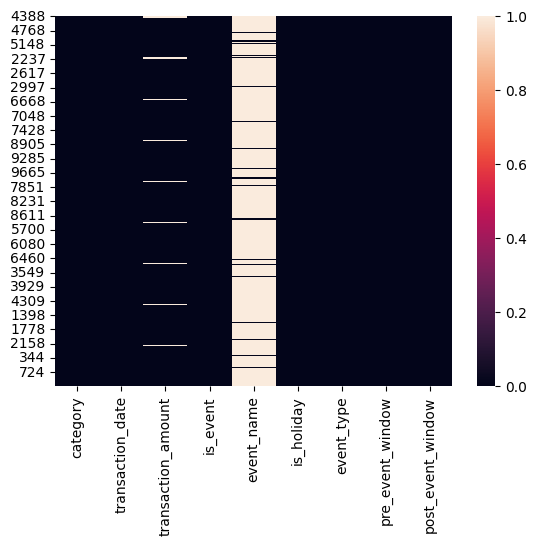

In [22]:
sns.heatmap(aggregated_df.isna())

<Axes: >

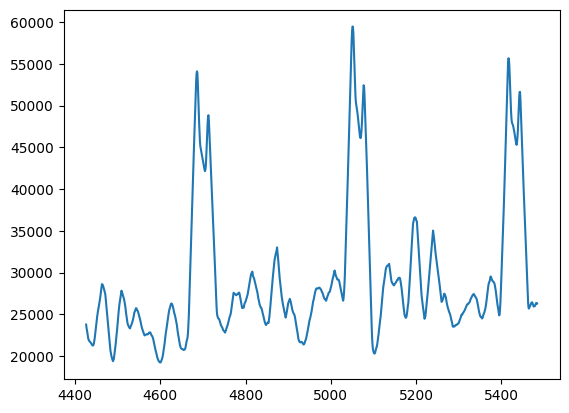

In [23]:
aggregated_df['transaction_amount'][aggregated_df['category'] == 'bank_transaction'].plot()

### 3.2 Making cyclical features for the dates

In [24]:
# Day of Week (0 to 6)
aggregated_df["day_of_week"] = aggregated_df["transaction_date"].dt.dayofweek
# Shift so that Sunday = 1, Monday = 2, ..., Saturday = 7
aggregated_df["day_of_week"] = ((aggregated_df["day_of_week"] + 1) % 7) + 1
aggregated_df["day_of_week_sin"] = np.sin(2 * np.pi * aggregated_df["day_of_week"] / 7)
aggregated_df["day_of_week_cos"] = np.cos(2 * np.pi * aggregated_df["day_of_week"] / 7)

# Month (1 to 12)
aggregated_df["month"] = aggregated_df["transaction_date"].dt.month
aggregated_df["month_sin"] = np.sin(2 * np.pi * aggregated_df["month"] / 12)
aggregated_df["month_cos"] = np.cos(2 * np.pi * aggregated_df["month"] / 12)


# Year (1 to 365)
aggregated_df["day_of_year"] = aggregated_df["transaction_date"].dt.dayofyear
aggregated_df["day_of_year_sin"] = np.sin(2 * np.pi * aggregated_df["day_of_year"] / 365)
aggregated_df["day_of_year_cos"] = np.cos(2 * np.pi * aggregated_df["day_of_year"] / 365)

In [25]:
aggregated_df.drop(columns=["day_of_week", "month", 'day_of_year'], inplace=True)

In [26]:
aggregated_df.shape

(9873, 15)

### 3.3 Removing the unwanted columns

In [27]:
aggregated_df.drop(columns=['event_name'], inplace=True)

### 3.4 Creating Lag features and rolling mean statistics

In [28]:
# Ensure the data is sorted by date
aggregated_df = aggregated_df.sort_values(["category", "transaction_date"])

# Create lag features
for lag in [1, 7, 14]:
    aggregated_df[f"lag_{lag}"] = aggregated_df.groupby("category")["transaction_amount"].shift(lag)


In [29]:
# Create 7-day and 30-day rolling means
for window in [7, 14]:
    aggregated_df[f"rolling_mean_{window}"] = (
        aggregated_df.groupby("category")["transaction_amount"]
        .transform(lambda x: x.shift(1).rolling(window=window).mean())
    )


### 3.4 Droping unwanted rows

In [30]:
aggregated_df.dropna(inplace=True)

In [31]:
aggregated_df.shape

(9405, 19)

# 4. Performing the train-test split

In [32]:
train_list, test_list = [], []

for cat in aggregated_df['category'].unique():
    df_cat = aggregated_df[aggregated_df['category'] == cat]
    cutoff = df_cat['transaction_date'].quantile(0.8)
    
    train_list.append(df_cat[df_cat['transaction_date'] <= cutoff])
    test_list.append(df_cat[df_cat['transaction_date'] > cutoff])

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)


In [33]:
train_df.head()

,category,transaction_date,transaction_amount,is_event,is_holiday,event_type,pre_event_window,post_event_window,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos,lag_1,lag_7,lag_14,rolling_mean_7,rolling_mean_14
4440,bank_transaction,2022-08-23,21333.807950,False,False,none,True,False,4.338837e-01,-0.900969,-0.866025,-0.5,-0.785650,-0.618671,21434.637500,21825.226400,23775.766200,21640.018886,22201.527471
4441,bank_transaction,2022-08-24,21279.445800,False,False,none,True,False,-4.338837e-01,-0.900969,-0.866025,-0.5,-0.796183,-0.605056,21333.807950,21769.034200,23340.468050,21569.816250,22027.101882
4442,bank_transaction,2022-08-25,21263.327800,False,False,none,True,False,-9.749279e-01,-0.222521,-0.866025,-0.5,-0.806480,-0.591261,21279.445800,21717.093925,23079.804675,21499.875050,21879.886007
4443,bank_transaction,2022-08-26,21307.950275,False,False,none,True,False,-7.818315e-01,0.623490,-0.866025,-0.5,-0.816538,-0.577292,21263.327800,21658.786875,22733.571450,21435.051318,21750.137659
4444,bank_transaction,2022-08-27,21487.090475,True,True,festival,False,False,-2.449294e-16,1.000000,-0.866025,-0.5,-0.826354,-0.563151,21307.950275,21590.597800,22395.019700,21384.931804,21648.307575


### 4.1.1 Encoding the categorical features using Target Encoding and One-Hot Encoding

In [34]:
# train_df.drop(columns=['transaction_date'], inplace=True)
# test_df.drop(columns=['transaction_date'], inplace=True)

In [35]:
# Step 1: Compute mean target value per category (from training data only)
category_target_mean = train_df.groupby('category')['transaction_amount'].mean()

# Step 2: Map encoded values to both train and test sets
train_df['category'] = train_df['category'].map(category_target_mean)
test_df['category'] = test_df['category'].map(category_target_mean)

# Step 3 (optional): Fill NaNs in test set (in case unseen categories exist)
global_mean = train_df['transaction_amount'].mean()
test_df['category'].fillna(global_mean, inplace=True)


C:\Users\JARVIS\AppData\Local\Temp\ipykernel_14068\1161719989.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['category'].fillna(global_mean, inplace=True)


In [36]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# 2. Create and fit encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train_df[['event_type']])

# 3. Transform both train and test
train_encoded = encoder.transform(train_df[['event_type']])
test_encoded = encoder.transform(test_df[['event_type']])

# 4. Get encoded column names
encoded_cols = encoder.get_feature_names_out(['event_type'])

# 5. Convert to DataFrame
train_encoded_df = pd.DataFrame(train_encoded, columns=encoded_cols, index=train_df.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_cols, index=test_df.index)

# 6. Merge with original DataFrames
train_df = pd.concat([train_df.drop(columns=['event_type']), train_encoded_df], axis=1)
test_df = pd.concat([test_df.drop(columns=['event_type']), test_encoded_df], axis=1)


In [37]:
X_train = train_df.dropna(subset=['transaction_amount']).drop(columns=['transaction_amount', 'transaction_date'])
X_test = test_df.dropna(subset=['transaction_amount']).drop(columns=['transaction_amount', 'transaction_date'])

y_train = train_df['transaction_amount']
y_test = test_df['transaction_amount']


In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7524 entries, 4440 to 887
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   category             7524 non-null   float64       
 1   transaction_date     7524 non-null   datetime64[ns]
 2   transaction_amount   7524 non-null   float64       
 3   is_event             7524 non-null   bool          
 4   is_holiday           7524 non-null   bool          
 5   pre_event_window     7524 non-null   bool          
 6   post_event_window    7524 non-null   bool          
 7   day_of_week_sin      7524 non-null   float64       
 8   day_of_week_cos      7524 non-null   float64       
 9   month_sin            7524 non-null   float64       
 10  month_cos            7524 non-null   float64       
 11  day_of_year_sin      7524 non-null   float64       
 12  day_of_year_cos      7524 non-null   float64       
 13  lag_1                7524 non-null  

# 5. Training the model

In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7524 entries, 4440 to 887
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   category             7524 non-null   float64       
 1   transaction_date     7524 non-null   datetime64[ns]
 2   transaction_amount   7524 non-null   float64       
 3   is_event             7524 non-null   bool          
 4   is_holiday           7524 non-null   bool          
 5   pre_event_window     7524 non-null   bool          
 6   post_event_window    7524 non-null   bool          
 7   day_of_week_sin      7524 non-null   float64       
 8   day_of_week_cos      7524 non-null   float64       
 9   month_sin            7524 non-null   float64       
 10  month_cos            7524 non-null   float64       
 11  day_of_year_sin      7524 non-null   float64       
 12  day_of_year_cos      7524 non-null   float64       
 13  lag_1                7524 non-null  

In [40]:
train_df.head()

,category,transaction_date,transaction_amount,is_event,is_holiday,pre_event_window,post_event_window,day_of_week_sin,day_of_week_cos,month_sin,...,day_of_year_sin,day_of_year_cos,lag_1,lag_7,lag_14,rolling_mean_7,rolling_mean_14,event_type_disaster,event_type_festival,event_type_none
4440,28702.08916,2022-08-23,21333.807950,False,False,True,False,4.338837e-01,-0.900969,-0.866025,...,-0.785650,-0.618671,21434.637500,21825.226400,23775.766200,21640.018886,22201.527471,0.0,0.0,1.0
4441,28702.08916,2022-08-24,21279.445800,False,False,True,False,-4.338837e-01,-0.900969,-0.866025,...,-0.796183,-0.605056,21333.807950,21769.034200,23340.468050,21569.816250,22027.101882,0.0,0.0,1.0
4442,28702.08916,2022-08-25,21263.327800,False,False,True,False,-9.749279e-01,-0.222521,-0.866025,...,-0.806480,-0.591261,21279.445800,21717.093925,23079.804675,21499.875050,21879.886007,0.0,0.0,1.0
4443,28702.08916,2022-08-26,21307.950275,False,False,True,False,-7.818315e-01,0.623490,-0.866025,...,-0.816538,-0.577292,21263.327800,21658.786875,22733.571450,21435.051318,21750.137659,0.0,0.0,1.0
4444,28702.08916,2022-08-27,21487.090475,True,True,False,False,-2.449294e-16,1.000000,-0.866025,...,-0.826354,-0.563151,21307.950275,21590.597800,22395.019700,21384.931804,21648.307575,0.0,1.0,0.0


In [41]:
X_train.head()

,category,is_event,is_holiday,pre_event_window,post_event_window,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos,lag_1,lag_7,lag_14,rolling_mean_7,rolling_mean_14,event_type_disaster,event_type_festival,event_type_none
4440,28702.08916,False,False,True,False,4.338837e-01,-0.900969,-0.866025,-0.5,-0.785650,-0.618671,21434.637500,21825.226400,23775.766200,21640.018886,22201.527471,0.0,0.0,1.0
4441,28702.08916,False,False,True,False,-4.338837e-01,-0.900969,-0.866025,-0.5,-0.796183,-0.605056,21333.807950,21769.034200,23340.468050,21569.816250,22027.101882,0.0,0.0,1.0
4442,28702.08916,False,False,True,False,-9.749279e-01,-0.222521,-0.866025,-0.5,-0.806480,-0.591261,21279.445800,21717.093925,23079.804675,21499.875050,21879.886007,0.0,0.0,1.0
4443,28702.08916,False,False,True,False,-7.818315e-01,0.623490,-0.866025,-0.5,-0.816538,-0.577292,21263.327800,21658.786875,22733.571450,21435.051318,21750.137659,0.0,0.0,1.0
4444,28702.08916,True,True,False,False,-2.449294e-16,1.000000,-0.866025,-0.5,-0.826354,-0.563151,21307.950275,21590.597800,22395.019700,21384.931804,21648.307575,0.0,1.0,0.0


In [42]:
from xgboost import XGBRegressor

# Train
model_xgb = XGBRegressor(n_estimators=100)
model_xgb.fit(X_train, y_train)

# Predict
y_pred = model_xgb.predict(X_test)

# 6. Evaluation

In [43]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7524 entries, 4440 to 887
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   category             7524 non-null   float64       
 1   transaction_date     7524 non-null   datetime64[ns]
 2   transaction_amount   7524 non-null   float64       
 3   is_event             7524 non-null   bool          
 4   is_holiday           7524 non-null   bool          
 5   pre_event_window     7524 non-null   bool          
 6   post_event_window    7524 non-null   bool          
 7   day_of_week_sin      7524 non-null   float64       
 8   day_of_week_cos      7524 non-null   float64       
 9   month_sin            7524 non-null   float64       
 10  month_cos            7524 non-null   float64       
 11  day_of_year_sin      7524 non-null   float64       
 12  day_of_year_cos      7524 non-null   float64       
 13  lag_1                7524 non-null  

In [44]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

mae_xgb = mean_absolute_error(y_test, y_pred)
print("MAE:", mae_xgb)

r2_xgb = r2_score(y_test, y_pred)
print("R-squared:", r2_xgb)

mape_xgb = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE:", mape_xgb)

MAE: 379.9086184135766
R-squared: 0.9905915579120601
MAPE: 0.008760176121288472


# 7. Forecasting

In [45]:
_transaction_df = None  # cache in memory


def load_transaction_data(refresh=False) -> pd.DataFrame:
    global _transaction_df

    if _transaction_df is None or refresh:
        df = pd.read_csv('../../project/data/synthetic_data_v5.csv')  # or query DB
        df['transaction_date'] = pd.to_datetime(df['transaction_date'], dayfirst=True)
        df['category'] = df['category'].astype(str)
        df['product'] = df['product'].astype(str)
        _transaction_df = df

    return _transaction_df.copy()


def get_past_days_data_category(category_name, past_days=30):
    today = datetime.datetime.today()
    start_date = today - timedelta(days=past_days+1)
    end_date = today - timedelta(days=1)
    df = load_transaction_data()
    df = df[df['category'] == category_name]
    df = df[df['transaction_date'].between(start_date, end_date)]

    aggregated_df = df.groupby(["transaction_date"]).agg(
        transaction_count=("amount", "count"),
        transaction_amount=("amount", "sum")
    ).reset_index()
    
    # Reindex to include all date-category pairs
    aggregated_df = aggregated_df.set_index('transaction_date').asfreq('D', fill_value=0)

    # Reset index for further processing
    aggregated_df = aggregated_df.reset_index()
    
    return aggregated_df


In [46]:
import pandas as pd
import numpy as np
from datetime import timedelta
import requests

features = [
       'category', 'is_event', 'is_holiday',
       'pre_event_window', 'post_event_window', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year_sin',
       'day_of_year_cos', 'lag_1', 'lag_7', 'lag_14', 'rolling_mean_7',
       'rolling_mean_14', 'event_type_disaster', 'event_type_festival',
       'event_type_none'
       ]

def forecast_next_7_days_category(category_name, model, aggregated_df, category_target_mean, global_mean, target_col='transaction_amount'):
    # Step 1: Filter past data for this category
    aggregated_df.sort_values('transaction_date', inplace=True)
    aggregated_df.reset_index(drop=True, inplace=True)

    # Step 2: Prepare future dates
    last_date = aggregated_df['transaction_date'].max() 
    future_dates = pd.to_datetime([last_date + timedelta(days=i+1) for i in range(7)])

    forecasts = []
    
    for forecast_date in future_dates:
        row = {}
        row['transaction_date'] = forecast_date

        # === Static Features ===
        row['category'] = category_target_mean.get(category_name, global_mean)

        data = requests.get(f'http://127.0.0.1:8000/api/calender/info/{forecast_date}').json()
        row['is_event'] = data.get('is_event', False)
        row['is_holiday'] = data.get('is_holiday', False)
        row['pre_event_window'] = data.get('pre_event_window', False)
        row['post_event_window'] = data.get('post_event_window', False)

        # === Cyclical Features ===
        dow = forecast_date.weekday()  # Monday=0
        row["day_of_week"] = row["transaction_date"].dayofweek
        row["day_of_week"] = ((row["day_of_week"] + 1) % 7) + 1
        row['day_of_week_sin'] = np.sin(2 * np.pi * dow / 7)
        row['day_of_week_cos'] = np.cos(2 * np.pi * dow / 7)

        month = forecast_date.month
        row['month_sin'] = np.sin(2 * np.pi * month / 12)
        row['month_cos'] = np.cos(2 * np.pi * month / 12)

        day_of_year = forecast_date.dayofyear
        row['day_of_year_sin'] = np.sin(2 * np.pi * day_of_year / 365)
        row['day_of_year_cos'] = np.cos(2 * np.pi * day_of_year / 365)

        # === One-hot Event Type ===
        row['event_type_festival'] = data.get('event_type', 'none') == 'festival'
        row['event_type_disaster'] = data.get('event_type', 'none') == 'disaster'
        row['event_type_none'] = data.get('event_type', 'none') == 'none'

        # === Lag and Rolling ===
        # Make sure to handle missing lag values (e.g. beginning of series)
        try:
            row['lag_1'] = aggregated_df.iloc[-1][target_col]
            row['lag_7'] = aggregated_df.iloc[-7][target_col] if len(aggregated_df) >= 7 else row['lag_1']
            row['lag_14'] = aggregated_df.iloc[-14][target_col] if len(aggregated_df) >= 14 else row['lag_7']
        except IndexError:
            row['lag_1'] = row['lag_7'] = row['lag_14'] = aggregated_df[target_col].mean()

        row['rolling_mean_7'] = aggregated_df[target_col].rolling(window=7).mean().iloc[-1] if len(df_cat) >= 7 else df_cat['transaction_amount'].mean()
        row['rolling_mean_14'] = aggregated_df[target_col].rolling(window=14).mean().iloc[-1] if len(df_cat) >= 14 else df_cat['transaction_amount'].mean()

        # Convert to DataFrame and predict
        X = pd.DataFrame([row])
        prediction = model.predict(X[features])[0]
        row[target_col] = prediction

        # Append to results
        forecasts.append(row)

        # Append to aggregated_df to maintain rolling window
        aggregated_df = pd.concat([aggregated_df, pd.DataFrame({
            'transaction_date': [forecast_date],
            target_col: [prediction]
        })], ignore_index=True)

    return pd.DataFrame(forecasts)


In [47]:
df_30 = get_past_days_data_category('loan', past_days=30)

forecast_df = forecast_next_7_days_category(
    category_name='loan',
    model=model_xgb,
    aggregated_df=df_30,
    category_target_mean=category_target_mean,
    global_mean=global_mean
)
print(forecast_df[['transaction_date', 'transaction_amount']])


FileNotFoundError: [Errno 2] No such file or directory: '../../project/data/synthetic_data_v5.csv'

# 8. Saving the model

In [48]:
import pickle

with open('./models/xgb_model_category_amount.pkl', 'wb') as f:
    data = {
        'model': model_xgb,
        'category_target_mean': category_target_mean,
        'global_mean': global_mean,
    }
    pickle.dump(data, f)